# Machine Learning from Start to Finish with Scikit-Learn
## This tutorial uses [Titanic Survivors dataset from Kaggle](https://www.kaggle.com/c/titanic/data)
### September 6th 2019

In [57]:
### Import modules 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

## 1) Read Input data

In [58]:
data_train=pd.read_csv('train.csv')
data_test= pd.read_csv('test.csv')

data_train.sample(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
338,339,1,3,"Dahl, Mr. Karl Edwart",male,45.0,0,0,7598,8.0500,NaN,S
404,405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,NaN,S
420,421,0,3,"Gheorgheff, Mr. Stanio",male,NaN,0,0,349254,7.8958,NaN,C


In [59]:
data_test.sample(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
378,1270,1,"Hipkins, Mr. William Edward",male,55.0,0,0,680,50.0000,C39,S
13,905,2,"Howard, Mr. Benjamin",male,63.0,1,0,24065,26.0000,NaN,S
56,948,3,"Cor, Mr. Bartol",male,35.0,0,0,349230,7.8958,NaN,S


## 2) Visualizing Data

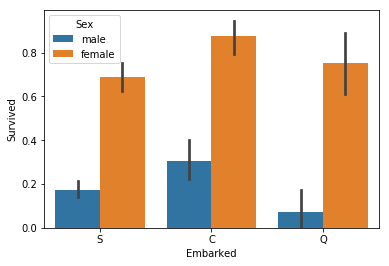

In [61]:
sns.barplot(x="Embarked",y="Survived",hue="Sex",data=data_train)

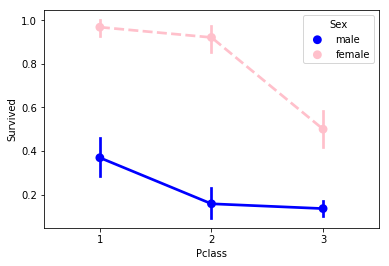

In [62]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex",data=data_train,
             palette={"male": "blue", "female": "pink"},linestyles=["-", "--"])

## 3) Transforming Features

In [63]:
data_train.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [64]:
data_train.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [65]:
def simplify_ages(df):
    df.Age= df.Age.fillna(-0.5)
    bins=(-1, 0, 5, 12, 18, 25,35,60,120)
    group_names= ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories= pd.cut(df.Age, bins, labels=group_names)
    df.Age= categories
    return df

# simplify_ages(df= data_train)

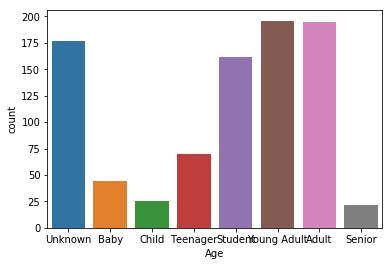

In [10]:
sns.countplot(x="Age",data=data_train)

In [66]:
def simplify_cabins(df):
    df.Cabin= df.Cabin.fillna('N')
    df.Cabin= df.Cabin.apply(lambda x: x[0])
    return df

# simplify_cabins(df= data_train)
# data_train

In [67]:
def simplify_fares(df):
    df.Fare= df.Fare.fillna(-0.5)
    bins= (-1,0,8,15,31,1000)
    group_names= ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories= pd.cut(df.Fare, bins, labels=group_names)
    df.Fare= categories
    return df

# simplify_fares(df=data_train)

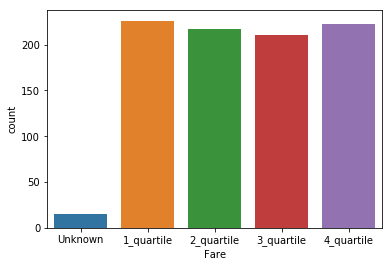

In [26]:
sns.countplot(x="Fare", data=data_train)

In [68]:
def format_name(df):
    df['Lname']= df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix']= df.Name.apply(lambda x: x.split(' ')[1])
    return df

# format_name(df= data_train)

In [69]:
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

# drop_features(df= data_train)

In [70]:
def transform_features(df):
    df= simplify_ages(df)
    df= simplify_cabins(df)
    df= simplify_fares(df)
    df= format_name(df)
    df= drop_features(df)
    return df

data_train= transform_features(data_train)
data_test= transform_features(data_test)
data_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.
5,6,0,3,male,Unknown,0,0,2_quartile,N,"Moran,",Mr.
6,7,0,1,male,Adult,0,0,4_quartile,E,"McCarthy,",Mr.
7,8,0,3,male,Baby,3,1,3_quartile,N,"Palsson,",Master.
8,9,1,3,female,Young Adult,0,2,2_quartile,N,"Johnson,",Mrs.
9,10,1,2,female,Teenager,1,0,3_quartile,N,"Nasser,",Mrs.


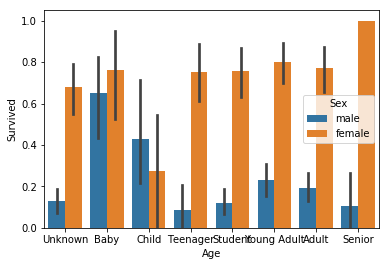

In [73]:
sns.barplot(x="Age", y="Survived",hue="Sex", data=data_train)

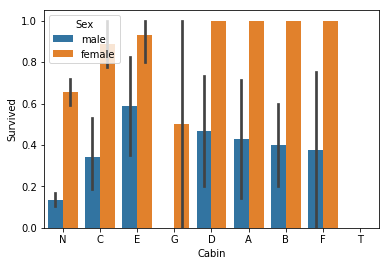

In [77]:
sns.barplot(x="Cabin", y="Survived",hue="Sex", data=data_train)